## 1. <font color = Green> Embedding Layer

Here We will be 
- Processing the text data
- Apply an effective and optimal chunking strategy
- Appropriate choices of embedding models and proper implementation of embeddings for all chunks

In [49]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [50]:
# Define the path where all pdf documents are present

pdf_path = 'pdfs/'

In [51]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [52]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [53]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [54]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [55]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [56]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Grief Support Services or any other value added service for the employees of that employer group. In addition, The Principal may arrange for third party service providers (i.e., optometrists, health clubs), to provide discounted goods and services to those employer groups who apply for coverage with The Principal or who become insureds/enrollees of The Principal. While The Principal has arranged these goods, services and/or third party provider discounts, the third party service providers are liable to the applicants/insureds/enrollees for the provision of such goods and/or services. The Principal is not responsible for the

In [57]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [58]:
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [59]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [60]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

/var/folders/rr/p5dx7kv906713t1tjgf5x2xw0000gn/T/ipykernel_35268/1081778557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [61]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


## 2. <font color = Green> Search Layer

In [62]:
# Set the API key
# filepath = "/content/drive/MyDrive/GenAI - Personal/HelpMate AI Codes/"

with open("api_key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [63]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [64]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/GenAI/HelpMate AI Codes/Week 3/ChromaDB_Data'

In [65]:
import chromadb

In [66]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [67]:
# Set up the embedding function using the OpenAI embedding model

# model = "text-embedding-ada-002"
model = "text-embedding-3-small"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

### Implementation of Caching

In [68]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [69]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [70]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

In [71]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022469419986009598,
   0.01871146820485592,
   -0.02729734405875206,
   -0.031290166079998016,
   -0.0036731369327753782,
   0.027923669666051865,
   0.0008538575493730605,
   0.023656828328967094,
   -0.016571523621678352,
   0.004253792576491833,
   -0.005251998547464609,
   0.004058065824210644,
   -0.006273039150983095,
   0.023252326995134354,
   -0.011299951933324337,
   0.030977005138993263,
   0.002877181861549616,
   -0.024726800620555878,
   0.03055945597589016,
   0.007920404896140099,
   0.006413309834897518,
   0.01886804960668087,
   0.00953188817948103,
   0.012689611874520779,
   -0.012356876395642757,
   -0.009440548717975616,
   0.017889415845274925,
   -0.021686512976884842,
   0.023526344448328018,
   0.0030223457142710686,
   0.013283316045999527,
   -0.0145490150898695,
   -0.03361279144883156,
   -0.041180890053510666,
   -0.00845539104193449,
   0.013531235978007317,
   -0.0026716687716543674,
   -0.003868863452225923

In [72]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [73]:
cache_collection.peek()

{'ids': ['Details of Member Accidental Death and Dismemberment Insurance',
  'Details on Support for Family and Medical Leave Act',
  'Details on Support for Layoff or Approved Leave of Absence',
  'Details on support for Sickness or Injury',
  'details of honda147',
  'what are the death benefits'],
 'embeddings': [[0.03267547860741615,
   0.057188671082258224,
   -0.002570462180301547,
   0.06877385079860687,
   -0.05940038710832596,
   0.03122733160853386,
   -0.0045814127661287785,
   0.04370773211121559,
   0.011308717541396618,
   0.013889052905142307,
   0.05147507041692734,
   -0.054608333855867386,
   0.002761354437097907,
   -0.03249116986989975,
   0.011927471496164799,
   0.005147506948560476,
   0.0500795803964138,
   0.008925856091082096,
   -0.03838907927274704,
   0.007918735034763813,
   -0.018509961664676666,
   0.05982166528701782,
   -0.014007537625730038,
   0.003088833298534155,
   -0.015508345328271389,
   -0.02891029417514801,
   0.013783733360469341,
   -0.0800

### Now, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [26]:
# Read the user query

query = input()

 Details on Support for Family and Medical Leave Act


In [74]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [75]:
cache_results

{'ids': [['Details on Support for Family and Medical Leave Act']],
 'distances': [[1.3244639862793343e-06]],
 'metadatas': [[{'distances0': '1.9450575295528387',
    'distances1': '1.94762505713127',
    'distances2': '1.9588575457288129',
    'distances3': '1.959139993963374',
    'distances4': '1.971606680515382',
    'distances5': '1.9742488757145982',
    'distances6': '1.9785489121842663',
    'distances7': '1.9799017969207229',
    'distances8': '1.9815475996899397',
    'distances9': '1.9831097738259151',
    'documents0': "(2) has been placed with the Member or spouse insured under this Group Policy by an authorized state placement agency or by order of a court; and (3) required documentation has been provided and the child is approved in Writing by The Principal as a Dependent Child. c. A Member's adopted child, if that child meets the requirements in a. above and the Member: (1) is a party in a law suit in which the Member is seeking the adoption of the child; or (2) has cust

In [76]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
results.items()

dict_items([('ids', [['8', '7', '31', '53', '51', '26', '47', '58', '36', '34']]), ('distances', [[1.9451010747482536, 1.9476528007966325, 1.9588698644569082, 1.9591788212648389, 1.971651902790258, 1.9742020891827667, 1.978570272572832, 1.9799539057008433, 1.981583253166808, 1.9831334039891682]]), ('metadatas', [[{'Page_No.': 'Page 11', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 10', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 34', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 56', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 54', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 29', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 50', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 61', 'Policy_Name': 'Principal-Sample-Life-Insurance-Policy'}, {'Page_No.': 'Page 39', 'Poli

In [77]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          try:
              Values.append(str(val[0][i]))
          except:
              pass


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Found in cache!


In [78]:
results_df

,IDs,Documents,Distances,Metadatas
0,8,(2) has been placed with the Member or spouse ...,1.9450575295528387,"{'Page_No.': 'Page 11', 'Policy_Name': 'Princi..."
1,7,T he legally recognized union of two eligible ...,1.94762505713127,"{'Page_No.': 'Page 10', 'Policy_Name': 'Princi..."
2,31,provided The Principal has been notified of th...,1.9588575457288129,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi..."
3,53,"If a Member sustains an injury, and as a resul...",1.959139993963374,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi..."
4,51,"f . claim requirements listed in PART IV, Sect...",1.971606680515382,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi..."
5,26,Insurance for which Proof of Good Health is re...,1.9742488757145982,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi..."
6,47,The Principal may require that a ADL Disabled ...,1.9785489121842663,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi..."
7,58,Section D - Claim Procedures Article 1 - Notic...,1.9799017969207229,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi..."
8,36,(1) the child is incapable of self-support as ...,1.9815475996899397,"{'Page_No.': 'Page 39', 'Policy_Name': 'Princi..."
9,34,b. a business assignment; or c. full-time stud...,1.9831097738259151,"{'Page_No.': 'Page 37', 'Policy_Name': 'Princi..."


### Implementation of Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

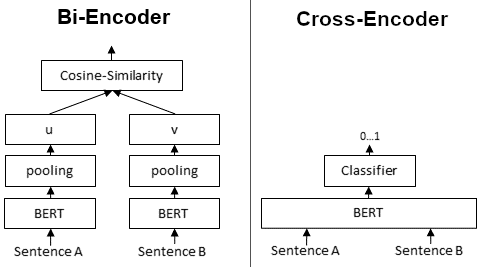

<br>

In [79]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [80]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

/Users/abhk/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [81]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover Family and Medical Leave Act?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover Family and Medical Leave Act?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [82]:
scores

array([ -4.3220673, -11.369946 ], dtype=float32)

In [83]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [84]:
cross_rerank_scores

array([-10.016632, -11.295965, -11.199531, -10.687066,  -9.062284,
        -9.607977,  -9.057673,  -9.963417,  -8.889121, -11.275983],
      dtype=float32)

In [85]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [86]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,8,(2) has been placed with the Member or spouse ...,1.9450575295528387,"{'Page_No.': 'Page 11', 'Policy_Name': 'Princi...",-10.016632
1,7,T he legally recognized union of two eligible ...,1.94762505713127,"{'Page_No.': 'Page 10', 'Policy_Name': 'Princi...",-11.295965
2,31,provided The Principal has been notified of th...,1.9588575457288129,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",-11.199531
3,53,"If a Member sustains an injury, and as a resul...",1.959139993963374,"{'Page_No.': 'Page 56', 'Policy_Name': 'Princi...",-10.687066
4,51,"f . claim requirements listed in PART IV, Sect...",1.971606680515382,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...",-9.062284
5,26,Insurance for which Proof of Good Health is re...,1.9742488757145982,"{'Page_No.': 'Page 29', 'Policy_Name': 'Princi...",-9.607977
6,47,The Principal may require that a ADL Disabled ...,1.9785489121842663,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",-9.057673
7,58,Section D - Claim Procedures Article 1 - Notic...,1.9799017969207229,"{'Page_No.': 'Page 61', 'Policy_Name': 'Princi...",-9.963417
8,36,(1) the child is incapable of self-support as ...,1.9815475996899397,"{'Page_No.': 'Page 39', 'Policy_Name': 'Princi...",-8.889121
9,34,b. a business assignment; or c. full-time stud...,1.9831097738259151,"{'Page_No.': 'Page 37', 'Policy_Name': 'Princi...",-11.275983


In [87]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,8,(2) has been placed with the Member or spouse ...,1.9450575295528387,"{'Page_No.': 'Page 11', 'Policy_Name': 'Princi...",-10.016632
1,7,T he legally recognized union of two eligible ...,1.94762505713127,"{'Page_No.': 'Page 10', 'Policy_Name': 'Princi...",-11.295965
2,31,provided The Principal has been notified of th...,1.9588575457288129,"{'Page_No.': 'Page 34', 'Policy_Name': 'Princi...",-11.199531


In [88]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
8,36,(1) the child is incapable of self-support as ...,1.9815475996899397,"{'Page_No.': 'Page 39', 'Policy_Name': 'Princi...",-8.889121
6,47,The Principal may require that a ADL Disabled ...,1.9785489121842663,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi...",-9.057673
4,51,"f . claim requirements listed in PART IV, Sect...",1.971606680515382,"{'Page_No.': 'Page 54', 'Policy_Name': 'Princi...",-9.062284


In [89]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [90]:
top_3_RAG

,Documents,Metadatas
8,(1) the child is incapable of self-support as ...,"{'Page_No.': 'Page 39', 'Policy_Name': 'Princi..."
6,The Principal may require that a ADL Disabled ...,"{'Page_No.': 'Page 50', 'Policy_Name': 'Princi..."
4,"f . claim requirements listed in PART IV, Sect...","{'Page_No.': 'Page 54', 'Policy_Name': 'Princi..."


### Response from Search Layer

In [91]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_search_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                {query}
                                                Please refer to the dataset {results_df}
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [92]:
print(f'Response from Search Layer')
print(f'\n Query : {query} \n')
print(generate_search_response(query, top_3_RAG))

Response from Search Layer

 Query : Details on Support for Family and Medical Leave Act 

['Based on the provided dataset, it seems that the information related to the Family and Medical Leave Act (FMLA) may not be available directly in the documents shared. However, in general, the FMLA is a federal law that provides eligible employees with up to 12 weeks of job-protected leave for specific family and medical reasons.', '', 'If you have any specific questions or need assistance regarding FMLA coverage or how it may apply to insurance policies, feel free to provide more details so I can offer more targeted support.']


## 3. <font color = Green> Generative Layer

In [93]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [94]:
# Generate the response

response = generate_response(query, top_3_RAG)

### Response from Generative Layer

In [95]:
# Print the response
print(f'Response from Generative Layer')
print(f'\n Query : {query} \n')
print("\n".join(response))

Response from Generative Layer

 Query : Details on Support for Family and Medical Leave Act 

The provided documents do not contain specific information related to the Family and Medical Leave Act. This query is irrelevant to the content in the given insurance documents.

Citation:
- Policy Name: Principal
- Relevant Pages: Page 39, Page 50, Page 54
